In [16]:
import os
import sys
import json
import numpy as np
import time
from PIL import Image, ImageDraw

In [17]:
# Set the ROOT_DIR variable to the root directory of the Mask_RCNN git repo
ROOT_DIR = './Mask_RCNN'
assert os.path.exists(ROOT_DIR), 'ROOT_DIR does not exist. Did you forget to read the instructions above? ;)'

# Import mrcnn libraries
sys.path.append(ROOT_DIR) 
from mrcnn.config import Config
import mrcnn.utils as utils
from mrcnn import visualize
import mrcnn.model as modellib

import tensorflow as tf
from keras import backend as k
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
config.gpu_options.per_process_gpu_memory_fraction = 0.9
k.tensorflow_backend.set_session(tf.Session(config=config))

## Set up logging and pre-trained model paths
This will default to sub-directories in your mask_rcnn_dir, but if you want them somewhere else, updated it here.

It will also download the pre-trained coco model.

In [18]:
# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")

# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

In [19]:
class DatasetConfig(Config):
    # Give the configuration a recognizable name
    NAME = "dataset"

    # Train on 1 GPU and 1 image per GPU. Batch size is 1 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

    # Number of classes (including background)
    NUM_CLASSES = 1 + 1  # background + 1 (house)

    # All of our training images are 768x1024
    IMAGE_MIN_DIM = 768
    IMAGE_MAX_DIM = 1024

    # You can experiment with this number to see if it improves training
    STEPS_PER_EPOCH = 150

    # This is how often validation is run. If you are using too much hard drive space
    # on saved models (in the MODEL_DIR), try making this value larger.
    VALIDATION_STEPS = 50
    
    # Matterport originally used resnet101, but I downsized to fit it on my graphics card
    BACKBONE = 'resnet50'

    # To be honest, I haven't taken the time to figure out what these do
    RPN_ANCHOR_SCALES = (4, 8, 16, 32, 64)
    TRAIN_ROIS_PER_IMAGE = 32
    MAX_GT_INSTANCES = 100 
    POST_NMS_ROIS_INFERENCE = 500 
    POST_NMS_ROIS_TRAINING = 1000 
    
config = DatasetConfig()
#config.display()

In [20]:
class CocoLikeDataset(utils.Dataset):
    """ Generates a COCO-like dataset, i.e. an image dataset annotated in the style of the COCO dataset.
        See http://cocodataset.org/#home for more information.
    """
    def load_data(self, annotation_json, images_dir):
        """ Load the coco-like dataset from json
        Args:
            annotation_json: The path to the coco annotations json file
            images_dir: The directory holding the images referred to by the json file
        """
        # Load json from file
        json_file = open(annotation_json)
        coco_json = json.load(json_file)
        json_file.close()
        
        # Add the class names using the base method from utils.Dataset
        source_name = "coco_like"
        for category in coco_json['categories']:
            class_id = category['id']
            class_name = category['name']
            if class_id < 1:
                print('Error: Class id for "{}" cannot be less than one. (0 is reserved for the background)'.format(class_name))
                return
            
            self.add_class(source_name, class_id, class_name)
        
        # Get all annotations
        annotations = {}
        for annotation in coco_json['annotations']:
            image_id = annotation['image_id']
            if image_id not in annotations:
                annotations[image_id] = []
            annotations[image_id].append(annotation)
        
        # Get all images and add them to the dataset
        seen_images = {}
        for image in coco_json['images']:
            image_id = image['id']
            if image_id in seen_images:
                print("Warning: Skipping duplicate image id: {}".format(image))
            else:
                seen_images[image_id] = image
                try:
                    image_file_name = image['file_name']
                    image_width = image['width']
                    image_height = image['height']
                except KeyError as key:
                    print("Warning: Skipping image (id: {}) with missing key: {}".format(image_id, key))
                
                image_path = os.path.abspath(os.path.join(images_dir, image_file_name))
                image_annotations = annotations[image_id]
                
                # Add the image using the base method from utils.Dataset
                self.add_image(
                    source=source_name,
                    image_id=image_id,
                    path=image_path,
                    width=image_width,
                    height=image_height,
                    annotations=image_annotations
                )
                
    def load_mask(self, image_id):
        """ Load instance masks for the given image.
        MaskRCNN expects masks in the form of a bitmap [height, width, instances].
        Args:
            image_id: The id of the image to load masks for
        Returns:
            masks: A bool array of shape [height, width, instance count] with
                one mask per instance.
            class_ids: a 1D array of class IDs of the instance masks.
        """
        image_info = self.image_info[image_id]
        annotations = image_info['annotations']
        instance_masks = []
        class_ids = []
        
        for annotation in annotations:
            class_id = annotation['category_id']
            mask = Image.new('1', (image_info['width'], image_info['height']))
            mask_draw = ImageDraw.ImageDraw(mask, '1')
            for segmentation in annotation['segmentation']:
                mask_draw.polygon(segmentation, fill=1)
                bool_array = np.array(mask) > 0
                instance_masks.append(bool_array)
                class_ids.append(class_id)

        mask = np.dstack(instance_masks)
        class_ids = np.array(class_ids, dtype=np.int32)
        
        return mask, class_ids

In [21]:
dataset_train = CocoLikeDataset()
dataset_train.load_data('./sat_images_close/train/train.json', './sat_images_close/train')
dataset_train.prepare()

dataset_val = CocoLikeDataset()
dataset_val.load_data('./sat_images_close/test/test.json', './sat_images_close/test')
dataset_val.prepare()

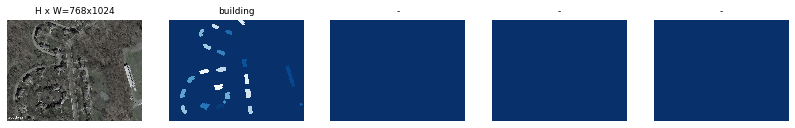

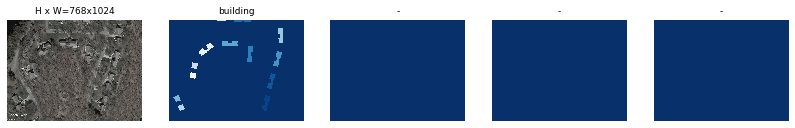

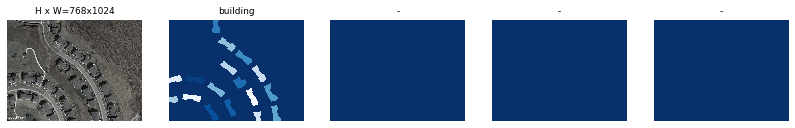

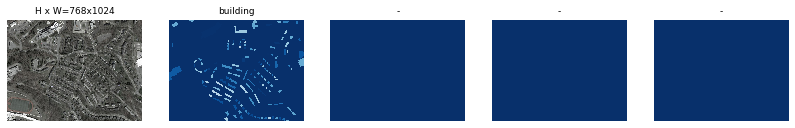

In [22]:
dataset = dataset_train
image_ids = np.random.choice(dataset.image_ids, 4)
for image_id in image_ids:
    image = dataset.load_image(image_id)
    mask, class_ids = dataset.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset.class_names)

In [23]:
# Create model in training mode
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)

In [24]:
# Which weights to start with?
init_with = "coco"  # imagenet, coco, or last

if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README for instructions to download the COCO weights
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    # Load the last model you trained and continue training
    model.load_weights(model.find_last(), by_name=True)

In [25]:
# Train the head branches
# Passing layers="heads" freezes all layers except the head
# layers. You can also pass a regular expression to select
# which layers to train by name pattern.
start_train = time.time()
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE, 
            epochs=96, 
            layers='heads')
end_train = time.time()
minutes = round((end_train - start_train) / 60, 2)
print(f'Training took {minutes} minutes')


Starting at epoch 0. LR=0.001

Checkpoint Path: ./Mask_RCNN/logs/dataset20190806T1918/mask_rcnn_dataset_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)
mrcnn_mask_bn4    

/usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/gradients_util.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/gradients_util.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/gradients_util.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/mnt/shared/bryan/.local/lib/python3.6/site-packages/keras/engine/training_generator.py:47: UserWarning: Using a generator with `use_multiprocessing=True` and m

Epoch 1/96
150/150 [==============================] - 170s 1s/step - loss: 2.4269 - rpn_class_loss: 0.1372 - rpn_bbox_loss: 1.3782 - mrcnn_class_loss: 0.1768 - mrcnn_bbox_loss: 0.2766 - mrcnn_mask_loss: 0.4580 - val_loss: 3.0257 - val_rpn_class_loss: 0.0661 - val_rpn_bbox_loss: 1.5268 - val_mrcnn_class_loss: 0.0981 - val_mrcnn_bbox_loss: 0.7121 - val_mrcnn_mask_loss: 0.6224
Epoch 2/96
150/150 [==============================] - 49s 329ms/step - loss: 1.9796 - rpn_class_loss: 0.0515 - rpn_bbox_loss: 1.2552 - mrcnn_class_loss: 0.1725 - mrcnn_bbox_loss: 0.1987 - mrcnn_mask_loss: 0.3018 - val_loss: 3.1305 - val_rpn_class_loss: 0.0670 - val_rpn_bbox_loss: 1.4880 - val_mrcnn_class_loss: 0.5785 - val_mrcnn_bbox_loss: 0.5760 - val_mrcnn_mask_loss: 0.4210
Epoch 3/96
150/150 [==============================] - 38s 255ms/step - loss: 2.0988 - rpn_class_loss: 0.0358 - rpn_bbox_loss: 1.4559 - mrcnn_class_loss: 0.1378 - mrcnn_bbox_loss: 0.1729 - mrcnn_mask_loss: 0.2964 - val_loss: 3.7007 - val_rpn_cla

Epoch 23/96
150/150 [==============================] - 40s 266ms/step - loss: 0.7348 - rpn_class_loss: 0.0171 - rpn_bbox_loss: 0.3683 - mrcnn_class_loss: 0.1004 - mrcnn_bbox_loss: 0.0695 - mrcnn_mask_loss: 0.1794 - val_loss: 2.3455 - val_rpn_class_loss: 0.0373 - val_rpn_bbox_loss: 1.3267 - val_mrcnn_class_loss: 0.2305 - val_mrcnn_bbox_loss: 0.2762 - val_mrcnn_mask_loss: 0.4748
Epoch 24/96
150/150 [==============================] - 44s 291ms/step - loss: 0.5212 - rpn_class_loss: 0.0177 - rpn_bbox_loss: 0.2059 - mrcnn_class_loss: 0.0738 - mrcnn_bbox_loss: 0.0510 - mrcnn_mask_loss: 0.1728 - val_loss: 2.4350 - val_rpn_class_loss: 0.0470 - val_rpn_bbox_loss: 1.4586 - val_mrcnn_class_loss: 0.2757 - val_mrcnn_bbox_loss: 0.2352 - val_mrcnn_mask_loss: 0.4185
Epoch 25/96
150/150 [==============================] - 40s 265ms/step - loss: 0.5328 - rpn_class_loss: 0.0152 - rpn_bbox_loss: 0.1962 - mrcnn_class_loss: 0.0923 - mrcnn_bbox_loss: 0.0549 - mrcnn_mask_loss: 0.1742 - val_loss: 2.4842 - val_rp

Epoch 45/96
150/150 [==============================] - 43s 287ms/step - loss: 0.2932 - rpn_class_loss: 0.0097 - rpn_bbox_loss: 0.0574 - mrcnn_class_loss: 0.0707 - mrcnn_bbox_loss: 0.0353 - mrcnn_mask_loss: 0.1200 - val_loss: 2.4432 - val_rpn_class_loss: 0.0415 - val_rpn_bbox_loss: 1.3826 - val_mrcnn_class_loss: 0.3153 - val_mrcnn_bbox_loss: 0.2218 - val_mrcnn_mask_loss: 0.4820
Epoch 46/96
150/150 [==============================] - 43s 287ms/step - loss: 0.2961 - rpn_class_loss: 0.0080 - rpn_bbox_loss: 0.0610 - mrcnn_class_loss: 0.0648 - mrcnn_bbox_loss: 0.0338 - mrcnn_mask_loss: 0.1286 - val_loss: 2.9252 - val_rpn_class_loss: 0.0457 - val_rpn_bbox_loss: 1.4680 - val_mrcnn_class_loss: 0.4815 - val_mrcnn_bbox_loss: 0.2752 - val_mrcnn_mask_loss: 0.6548
Epoch 47/96
150/150 [==============================] - 46s 308ms/step - loss: 0.3001 - rpn_class_loss: 0.0072 - rpn_bbox_loss: 0.0670 - mrcnn_class_loss: 0.0670 - mrcnn_bbox_loss: 0.0332 - mrcnn_mask_loss: 0.1257 - val_loss: 2.8586 - val_rp

Epoch 67/96
150/150 [==============================] - 41s 272ms/step - loss: 0.1917 - rpn_class_loss: 0.0109 - rpn_bbox_loss: 0.0260 - mrcnn_class_loss: 0.0496 - mrcnn_bbox_loss: 0.0222 - mrcnn_mask_loss: 0.0831 - val_loss: 2.4280 - val_rpn_class_loss: 0.0394 - val_rpn_bbox_loss: 1.2778 - val_mrcnn_class_loss: 0.3802 - val_mrcnn_bbox_loss: 0.2178 - val_mrcnn_mask_loss: 0.5128
Epoch 68/96
150/150 [==============================] - 43s 283ms/step - loss: 0.1961 - rpn_class_loss: 0.0100 - rpn_bbox_loss: 0.0260 - mrcnn_class_loss: 0.0510 - mrcnn_bbox_loss: 0.0225 - mrcnn_mask_loss: 0.0866 - val_loss: 2.5724 - val_rpn_class_loss: 0.0488 - val_rpn_bbox_loss: 1.3275 - val_mrcnn_class_loss: 0.4345 - val_mrcnn_bbox_loss: 0.2230 - val_mrcnn_mask_loss: 0.5386
Epoch 69/96
150/150 [==============================] - 43s 286ms/step - loss: 0.1879 - rpn_class_loss: 0.0104 - rpn_bbox_loss: 0.0253 - mrcnn_class_loss: 0.0452 - mrcnn_bbox_loss: 0.0196 - mrcnn_mask_loss: 0.0875 - val_loss: 2.7286 - val_rp

Epoch 89/96
150/150 [==============================] - 51s 338ms/step - loss: 0.1889 - rpn_class_loss: 0.0092 - rpn_bbox_loss: 0.0285 - mrcnn_class_loss: 0.0520 - mrcnn_bbox_loss: 0.0181 - mrcnn_mask_loss: 0.0811 - val_loss: 2.5410 - val_rpn_class_loss: 0.0359 - val_rpn_bbox_loss: 1.2971 - val_mrcnn_class_loss: 0.3725 - val_mrcnn_bbox_loss: 0.2314 - val_mrcnn_mask_loss: 0.6042
Epoch 90/96
150/150 [==============================] - 51s 338ms/step - loss: 0.1866 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.0255 - mrcnn_class_loss: 0.0556 - mrcnn_bbox_loss: 0.0184 - mrcnn_mask_loss: 0.0794 - val_loss: 2.6932 - val_rpn_class_loss: 0.0363 - val_rpn_bbox_loss: 1.3373 - val_mrcnn_class_loss: 0.3229 - val_mrcnn_bbox_loss: 0.2303 - val_mrcnn_mask_loss: 0.7664
Epoch 91/96
150/150 [==============================] - 57s 380ms/step - loss: 0.1995 - rpn_class_loss: 0.0083 - rpn_bbox_loss: 0.0332 - mrcnn_class_loss: 0.0587 - mrcnn_bbox_loss: 0.0188 - mrcnn_mask_loss: 0.0805 - val_loss: 2.6912 - val_rp

In [26]:
# Fine tune all layers
# Passing layers="all" trains all layers. You can also 
# pass a regular expression to select which layers to
# train by name pattern.
start_train = time.time()
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE / 10,
            epochs=32, 
            layers="all")
end_train = time.time()
minutes = round((end_train - start_train) / 60, 2)
print(f'Training took {minutes} minutes')


Starting at epoch 96. LR=0.0001

Checkpoint Path: ./Mask_RCNN/logs/dataset20190806T1918/mask_rcnn_dataset_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_branch2b         (Conv2D)
bn3a_branch2b   

/usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/gradients_util.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/gradients_util.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/gradients_util.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/mnt/shared/bryan/.local/lib/python3.6/site-packages/keras/engine/training_generator.py:47: UserWarning: Using a generator with `use_multiprocessing=True` and m

Training took 0.54 minutes


# Prepare to run Inference
Create a new InferenceConfig, then use it to create a new model.

In [27]:
class InferenceConfig(DatasetConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    IMAGE_MIN_DIM = 1024
    IMAGE_MAX_DIM = 1024
    DETECTION_MIN_CONFIDENCE = 0.51
    

inference_config = InferenceConfig()

In [28]:
# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

In [29]:
# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")
model_path = model.find_last()

# Load trained weights (fill in path to trained weights here)
assert model_path != "", "Provide path to trained weights"
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

Loading weights from  ./Mask_RCNN/logs/dataset20190806T1918/mask_rcnn_dataset_0096.h5
Re-starting from epoch 96


Processing 1 images
image                    shape: (768, 1024, 3)        min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.04424  max:    0.99885  float32


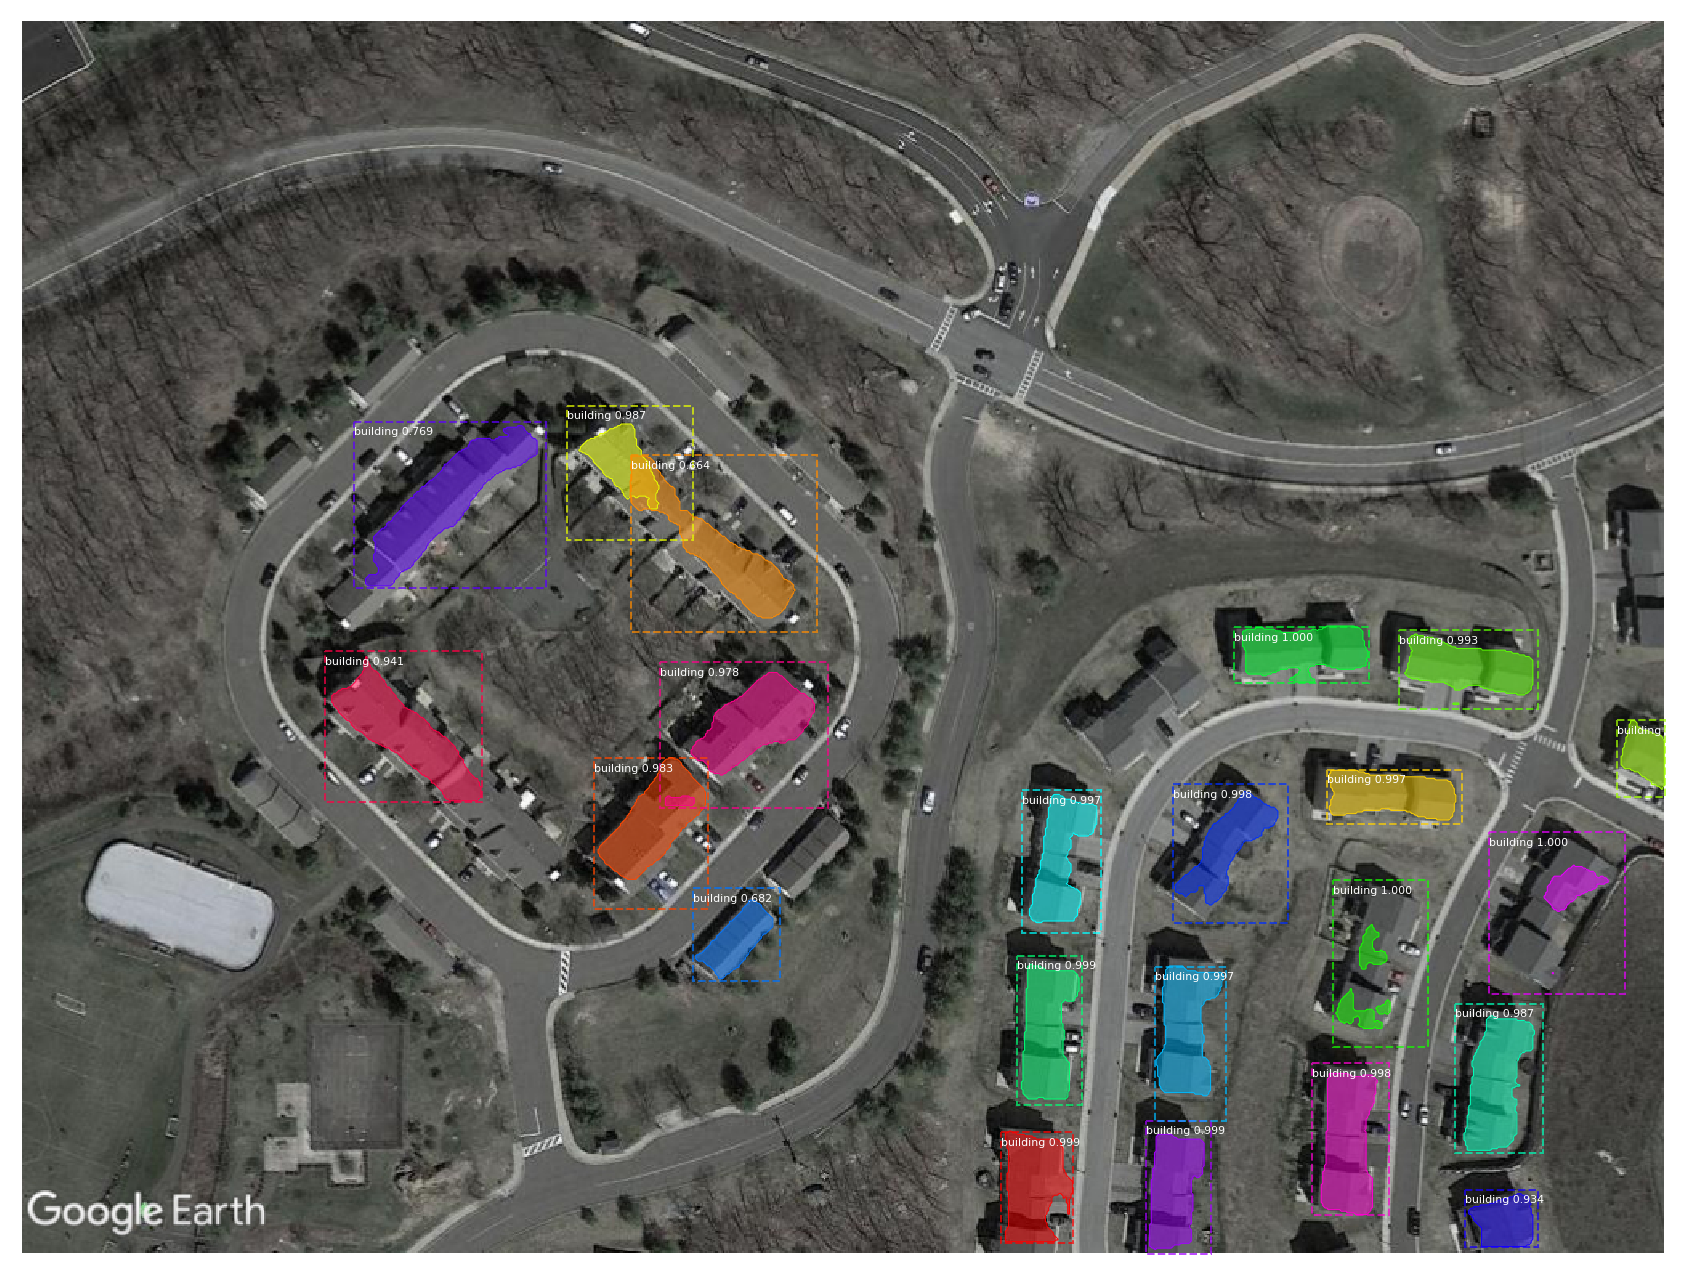

Processing 1 images
image                    shape: (594, 834, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.04424  max:    0.99885  float32


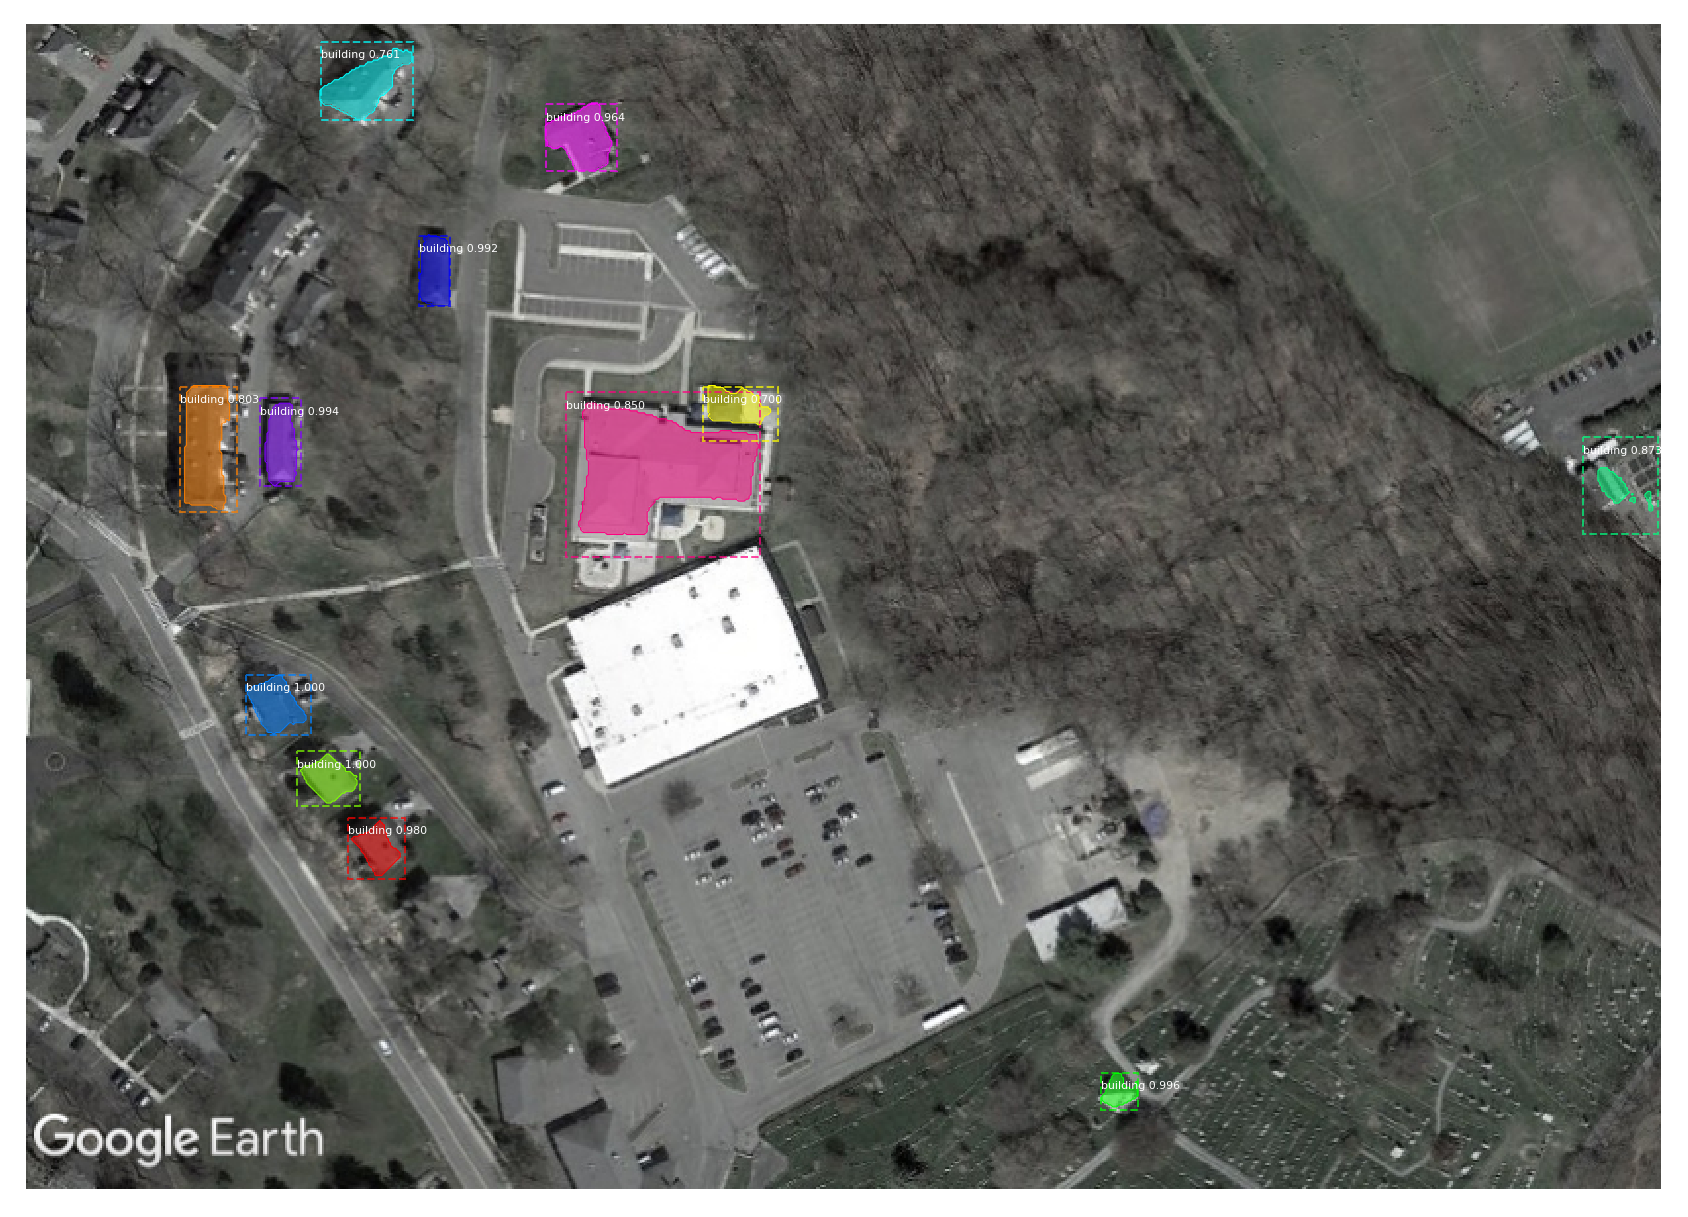

Processing 1 images
image                    shape: (594, 834, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.04424  max:    0.99885  float32


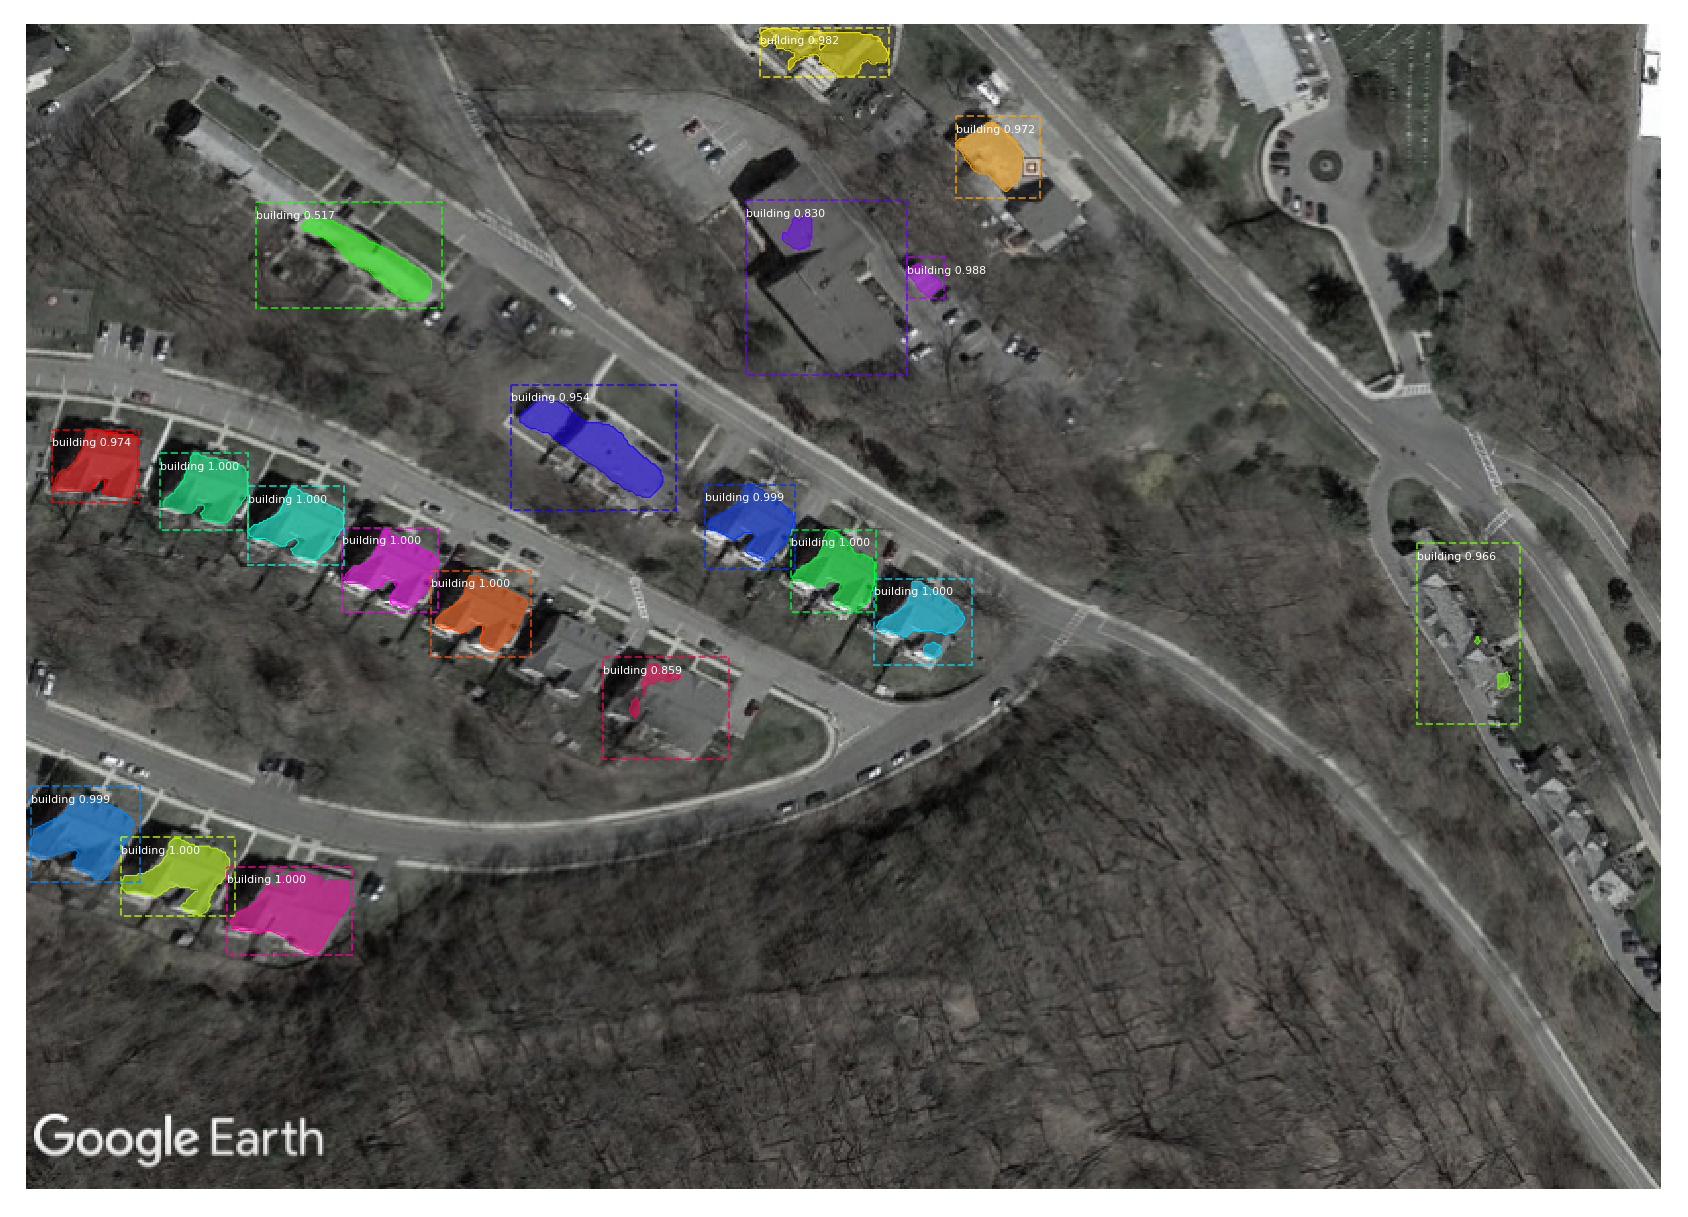

Processing 1 images
image                    shape: (594, 834, 3)         min:    0.00000  max:  254.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  148.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.04424  max:    0.99885  float32


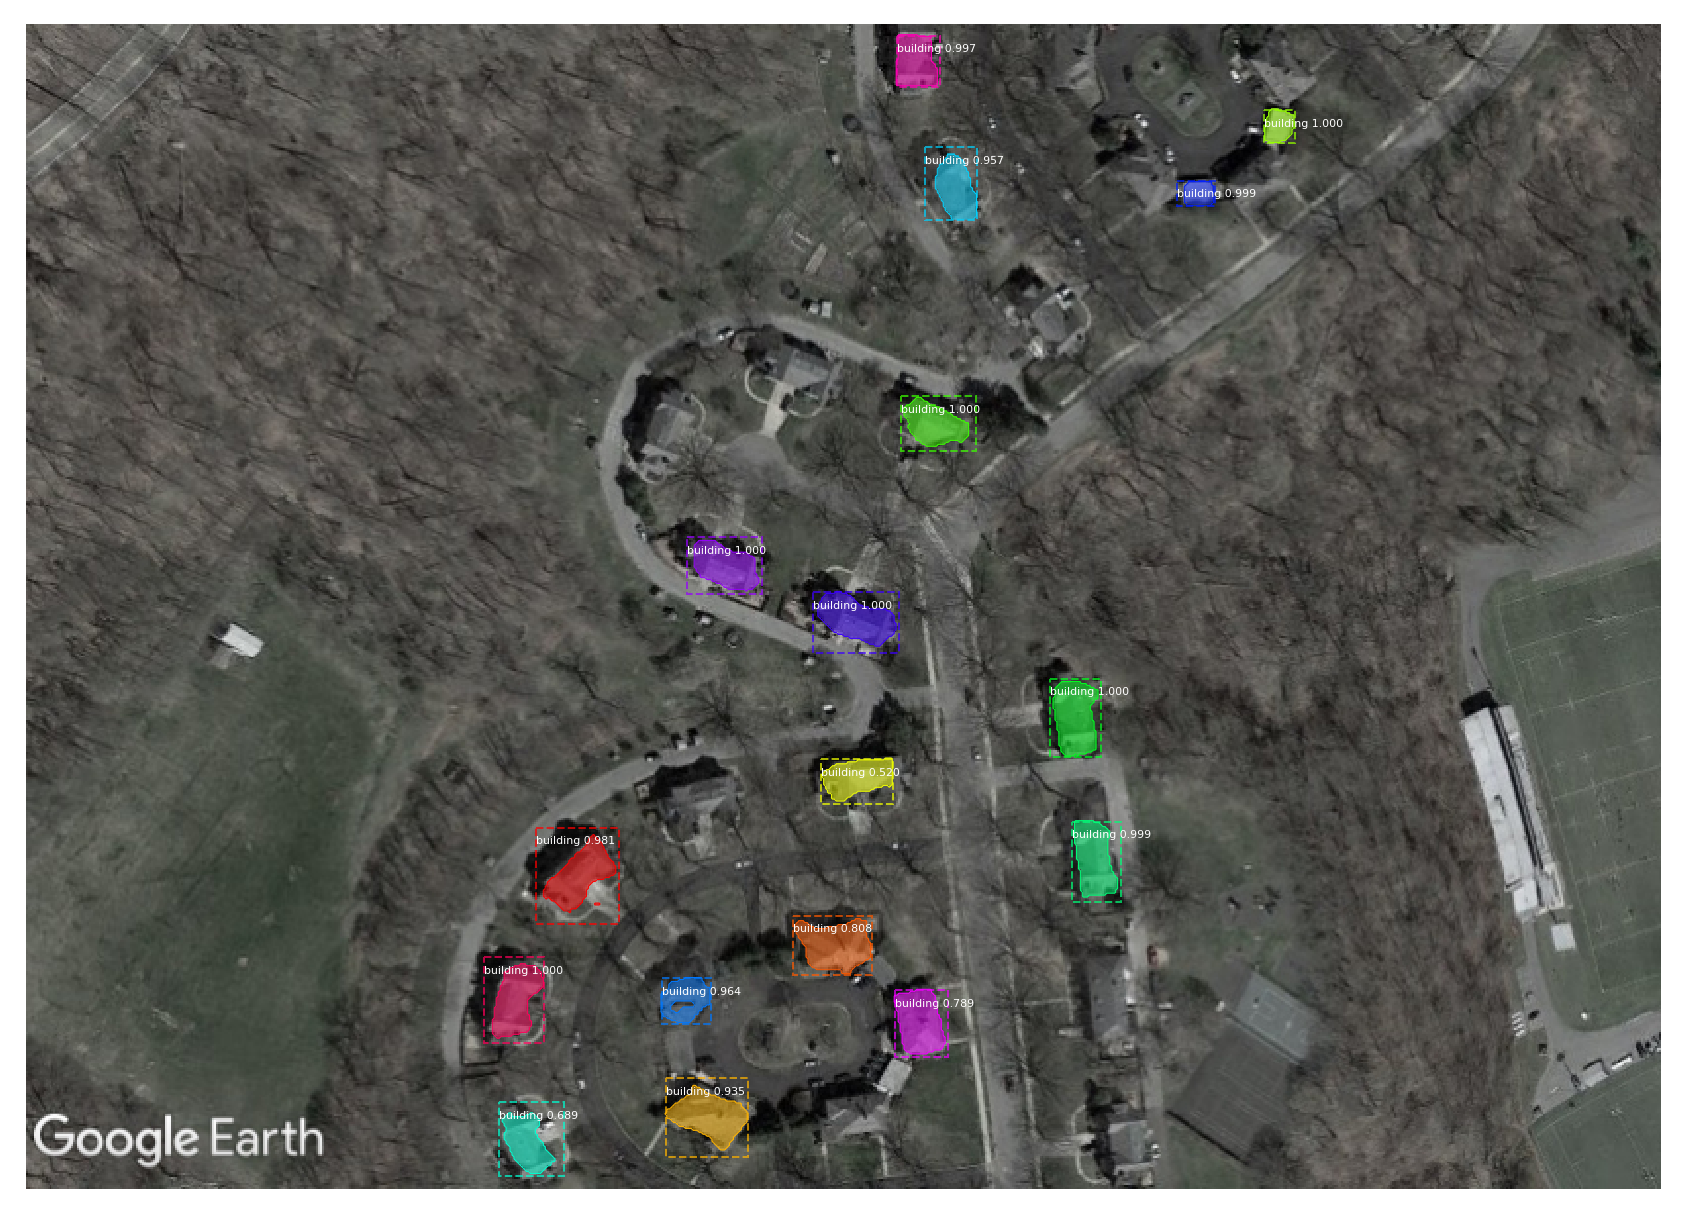

Processing 1 images
image                    shape: (768, 1024, 3)        min:    0.00000  max:  254.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  149.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.04424  max:    0.99885  float32


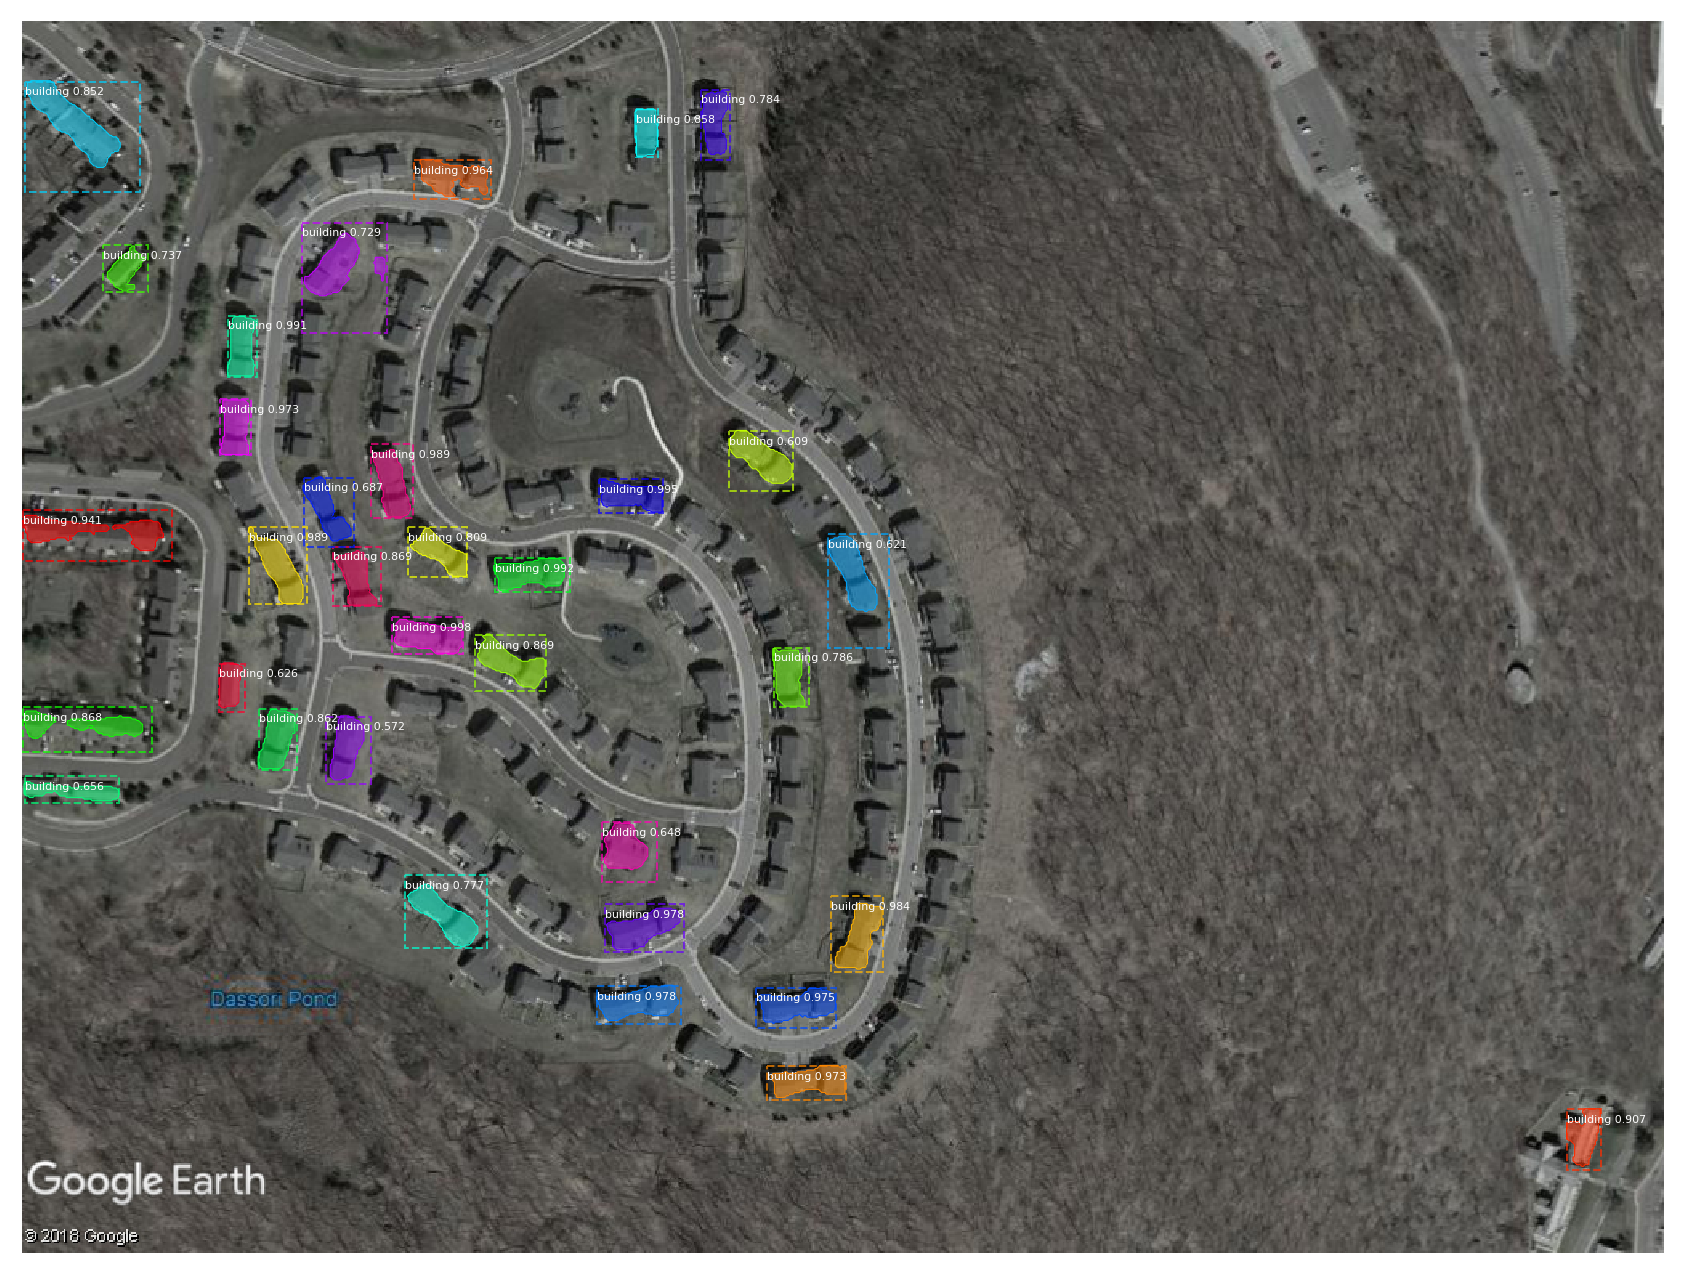

In [30]:
import skimage
real_test_dir = './sat_images_close/Inf/'
image_paths = []
for filename in os.listdir(real_test_dir):
    if os.path.splitext(filename)[1].lower() in ['.png', '.jpg', '.jpeg']:
        image_paths.append(os.path.join(real_test_dir, filename))

for image_path in image_paths:
    img = skimage.io.imread(image_path)
    img_arr = np.array(img)
    results = model.detect([img_arr], verbose=1)
    r = results[0]
    visualize.display_instances(img, r['rois'], r['masks'], r['class_ids'], 
                                dataset_val.class_names, r['scores'], figsize=(30,30))